In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="3"

In [2]:
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance

from unfold import *
from scripting import inf_unfold

2024-10-03 13:27:06.393585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 13:27:07.700893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data_size = 10**4
sim_size = 10**5
mu_true, mu_gen = 0, -1
smearings = np.linspace(0, 20)

iterations = 5
dims = 1

rng = np.random.default_rng()
truth = rng.normal(mu_true, 1, (data_size, 1))
gen = rng.normal(mu_gen, 1, (sim_size, 1))

gen_dist = []
of_dist = []
inf_unf_dist = []

In [6]:
for smearing in smearings:
    print(f"{smearing = }")
    data = truth * smearing
    sim = gen * smearing

    x_det = np.concatenate((data, sim))
    x_part = np.concatenate((truth, gen))
    y = np.concatenate((np.ones(data_size), np.zeros(sim_size)))
    
    x_det_train, x_det_test, x_part_train, x_part_test, y_train, y_test= train_test_split(x_det, x_part, y)
    weights, models, history, model = multifold(dims, iterations,
                                     x_part_train[y_train == 0], x_det_train[y_train==0], x_det_train[y_train==1], 
                                    )
    weights_omnifold = model.predict(x_part_test)
    weights_inf_unfold = inf_unfold.main(x_det_train, x_part_train, y_train, x_part_test, y_test)

    gen_dist += [wasserstein_distance(x_part_test[y_test == 1].squeeze(), x_part_test[y_test == 0].squeeze())]
    of_dist += [wasserstein_distance(x_part_test[y_test == 1].squeeze(), x_part_test[y_test == 0].squeeze(), 
                                           v_weights = weights_omnifold[y_test == 0])]
    inf_unf_dist += [wasserstein_distance(x_part_test[y_test == 1].squeeze(), x_part_test[y_test == 0].squeeze(), 
                                           v_weights = weights_inf_unfold)]

smearing = 0.0


2024-10-03 13:27:16.944543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14529 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3e:00.0, compute capability: 7.0
I0000 00:00:1727987238.223290 2108164 service.cc:145] XLA service 0x7fbf1800a460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727987238.223332 2108164 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-10-03 13:27:18.250631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 13:27:19.383923: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1727987240.569708 2108164 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step
smearing = 0.40816326530612246
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
smearing = 0.8163265306122449
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step
smearing = 1.2244897959183674
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
smearing = 1.6326530612244898
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step
smearing = 2.0408163265306123
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step
smearing = 2.4489795918367347
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
smearing = 2.857142857142857
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step
smearing = 3.2653061224489797
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
smearing = 3.673469387755102
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
smearing = 4.081632653061225
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step
smearing = 4.4897959183673475
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
smearing = 4.8979591836734695
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step
smearing = 5.3061224489795915
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step
smearing =

(1.0, 20.0)

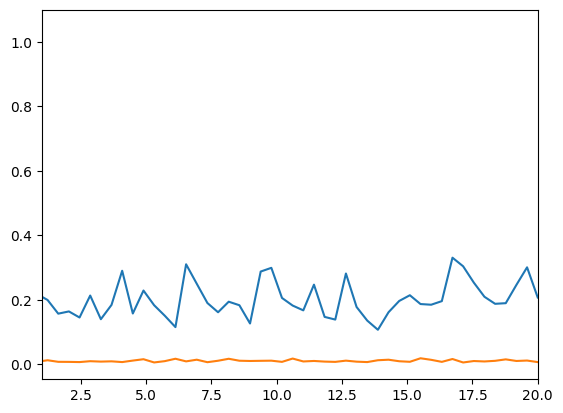

In [8]:
plt.plot(smearings, of_dist)
plt.plot(smearings, inf_unf_dist)
plt.xlim(1, 20)